In [1]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_data_from_file(path, meet_I = True):
    file = open(path, 'rt')
    info = file.read().split('\n')[:3]
    file.close()
    datadict = dict()
    for param in info:
        naam, value = param.split(' = ')
        datadict[naam] = eval(value)
    return datadict.copy()

def plot_const_T(proef, mode = 'Voltage', nulspanning = 2.6): #input: een proef (= dictionary)
    #hierin: alle spanningen in microvolts!

    I = np.array(proef['I'])
    V = np.array(proef['V'])*1e6 - nulspanning #de nulspanning eraf trekken
    T = np.array(proef['T'])
    R = V/I #micro-ohm
    #check whether temperature is approximately constant
    Tmean = round(np.mean(T),4)
    Tsd = round(np.sqrt(np.var(T)),4)
    titel = mode + ' as a function of current; T = ('+str(Tmean) +' $\\pm$ ' + str(Tsd) + ') K'
    #plot it
    fig, ax = plt.subplots(1,1)
    if mode == 'Voltage':
        plotparam = V
    elif mode == 'Resistance':
        plotparam = R
    ax.errorbar(I, plotparam, fmt = 'o')
    ax.set_xlabel('Current [A]')
    if mode == 'Voltage':
        ax.set_ylabel('Voltage [µV]')
    elif mode == 'Resistance':
        ax.set_ylabel('Resistance [$µ\\Omega$]')
    ax.set_title(titel)
    plt.tight_layout()
    plt.show()

def plot_const_I(proef, mode = 'Voltage', nulspanning = 2.6): #input: een proef (= dictionary)
    #hierin: alle spanningen in microvolts!

    I = np.array(proef['I'])
    V = np.array(proef['V'])*1e6 - nulspanning #de nulspanning eraf trekken
    T = np.array(proef['T'])
    R = V/I #micro-ohm
    #check whether temperature is approximately constant
    Imean = round(np.mean(I),4)
    Isd = round(np.sqrt(np.var(I)),4)
    titel = mode + ' as a function of temperature; I = ('+str(Tmean) +' $\\pm$ ' + str(Tsd) + ') K'
    #plot it
    fig, ax = plt.subplots(1,1)
    if mode == 'Voltage':
        plotparam = V
    elif mode == 'Resistance':
        plotparam = R
    ax.errorbar(T, plotparam, fmt = 'o')
    ax.set_xlabel('Temperature [K]')
    if mode == 'Voltage':
        ax.set_ylabel('Voltage [µV]')
    elif mode == 'Resistance':
        ax.set_ylabel('Resistance [$µ\\Omega$]')
    ax.set_title(titel)
    plt.tight_layout()
    plt.show()

def concatenate_experiments(experimenten): #input: een lijst met experimenten, elk als dictionary
    geconcateneerd = {'I':[], 'V': [], 'T': []}
    params = geconcateneerd.keys()
    for experiment in experimenten:
        for param in params:
            geconcateneerd[param] += experiment[param]
    return geconcateneerd

[{'I': [0.01000073, 0.02000677, 0.02999973, 0.03999152, 0.04999768, 0.06000254], 'V': [1.80803154e-06, 2.21128864e-06, 2.7041943e-06, 1.28161761e-06, 2.12172979e-06, 1.86963503e-06], 'T': [81.16004980514421, 81.1554181605612, 81.16045643024164, 81.15876282151208, 81.16031519875293, 81.16055206547156]}, {'I': [0.09987045, 0.2000703, 0.300195, 0.4002659, 0.5004269, 0.6006182, 0.7007048, 0.8007531, 0.9009056, 1.001108], 'V': [2.0321471e-06, 2.62574767e-06, 2.80490027e-06, 2.57521999e-06, 1.55615002e-06, 2.20563438e-06, 1.24243924e-06, 8.00039211e-07, 4.47190153e-07, -1.1096649e-06], 'T': [81.50040880748247, 81.50424099766174, 81.50671418550273, 81.51286687451287, 81.51396983632112, 81.51890919719409, 81.52513039750585, 81.53758986749806, 81.5526473889322, 81.56993024162121]}, {'I': [0.01000105, 0.02000673, 0.02999977, 0.0399916, 0.04999773, 0.06000257, 0.06999379, 0.07998557, 0.08999117, 0.09999467], 'V': [-2.45927692e-06, -2.98568712e-06, -2.19603401e-06, -1.32243375e-06, -7.45641148e-07

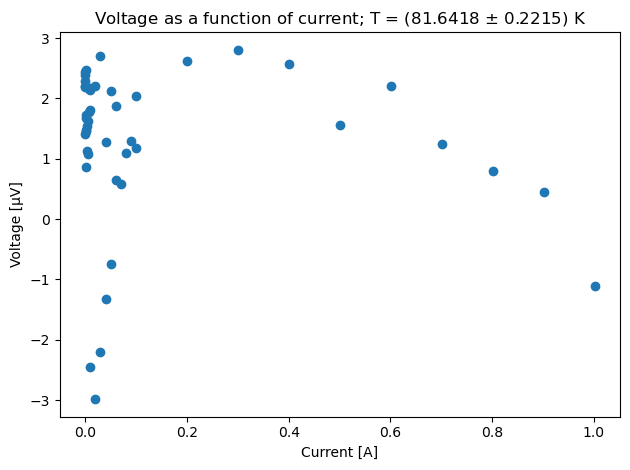

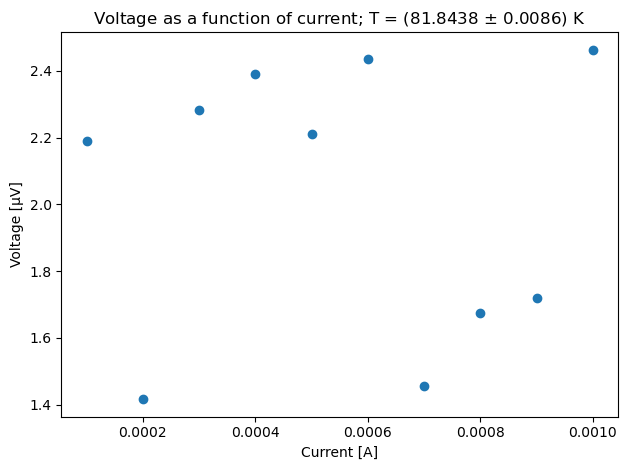

In [ ]:
proef_5 = get_data_from_file('data_superconductor/test5.txt')

adres = lambda i : 'data_superconductor/test'  + str(i) + '.txt'
print([get_data_from_file(adres(i)) for i in range(1,6)])
proeven_reeks_1 = concatenate_experiments([get_data_from_file(adres(i)) for i in range(1,6)])



#volledig reeks 1
plot_const_T(proeven_reeks_1, 'Voltage', nulspanning = 0)
#enkel proef 5 (kleinste orde)
plot_const_T(proef_5, 'Voltage', nulspanning= 0)

In [71]:
Temp_proef_3= get_data_from_file('data_superconductor/R_T_testing3.txt')
plot_const_I(Temp_proef_3)


ValueError: not enough values to unpack (expected 2, got 1)